# Clustering of neurons based on shapes of tuning curves

In [1]:
### imports ###
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sc

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim


import pickle


# add paths to access shared code
import sys
sys.path.append("..")
sys.path.append("../scripts/")

# import library implementing models
import neuroprob as nprb
from neuroprob import utils

# import utility code for model building/training/loading
import lib
import HDC

# get GPU device if available
gpu_dev = 0
dev = utils.pytorch.get_device(gpu=gpu_dev)

# use custom plotting settings
import matplotlib.pyplot as plt

#plt.style.use(['paper.mplstyle'])

# useful colormap
white = '#ffffff'
red = '#ff0000'
blue = '#0000ff'
weight_map = utils.plot.make_cmap([blue, white, red], 'weight_map')

PyTorch version: 1.12.1+cpu
Using device: cpu


## Load model and dataset <a class="anchor" id="loading"></a>

In [3]:
checkpoint_dir = '../example/'
session_id = '12-120806'
phase = 'wake'

single_spikes = False
dt = 0.001

ll_mode = 'Uqd3'  # stands for universal count model with exponential-quadratic expansion and C = 3
filt_mode = ''
map_mode = 'svgp64'  # a sparse variational GP mapping with 64 inducing points
x_mode = 'hd-w-s-pos-t'  # observed covariates (behaviour)
z_mode = ''  # latent covariates
hist_len = 0
folds = 5  # cross-validation folds
delays = [0]
model_info = (ll_mode, filt_mode, map_mode, x_mode, z_mode, hist_len, folds, delays)

In [4]:
bin_size = 50  # ms
cv_run = -1  # test set is last 1/5 of dataset time series
delay = 0
batch_size = 5000  # size of time segments of each batch in dataset below


# data
dataset_tuple = HDC.get_dataset(session_id, phase, bin_size, single_spikes, path='../data/')

# model and train/test split based on which validation fold is given by cv_run
modelfit, fit_set, validation_set = lib.models.load_model(
    checkpoint_dir, model_info, dataset_tuple, HDC.inputs_used, HDC.enc_used,
    delay, cv_run, batch_size, gpu_dev, tensor_type=torch.float, jitter=1e-5
)

C:\Users\valen\UCM-interpret\scripts\HDC.py:127: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  ('SE', 'torus', torch.tensor([l_ang])),


## Compute spike count distributions

In [45]:
rcov, units_used, tbin, resamples, rc_t, max_count, bin_size, metainfo, data_name = dataset_tuple

hd_sweep = torch.linspace(0, 2 * np.pi, 100)

covariates = torch.cat([
    hd_sweep[:, None],  # sweep over head direction
    *[rcov[k].mean() * torch.ones((100, 1)) for k in range(1, len(rcov))],
    # fill other behavioural covariates at value 0
], dim=-1)[None, None, ...]  # (tr, neurons, steps, covariate dims)

P_list = []

with torch.no_grad():
    P_mc = lib.helper.compute_P(
        modelfit, covariates, list(range(units_used)), MC=30,
        trials=1)  # predictive posterior
P_mc = P_mc.cpu()  # count probabilities of shape (MC, neurons, steps, count)

## Compute tuning curves

In [49]:
K = P_mc.shape[-1]
counts = torch.arange(K)

hd_mean = (counts[None, None, None, :] * P_mc).sum(-1)  # (MC, neurons, steps)
hd_rate = hd_mean / tbin  # in units of Hz

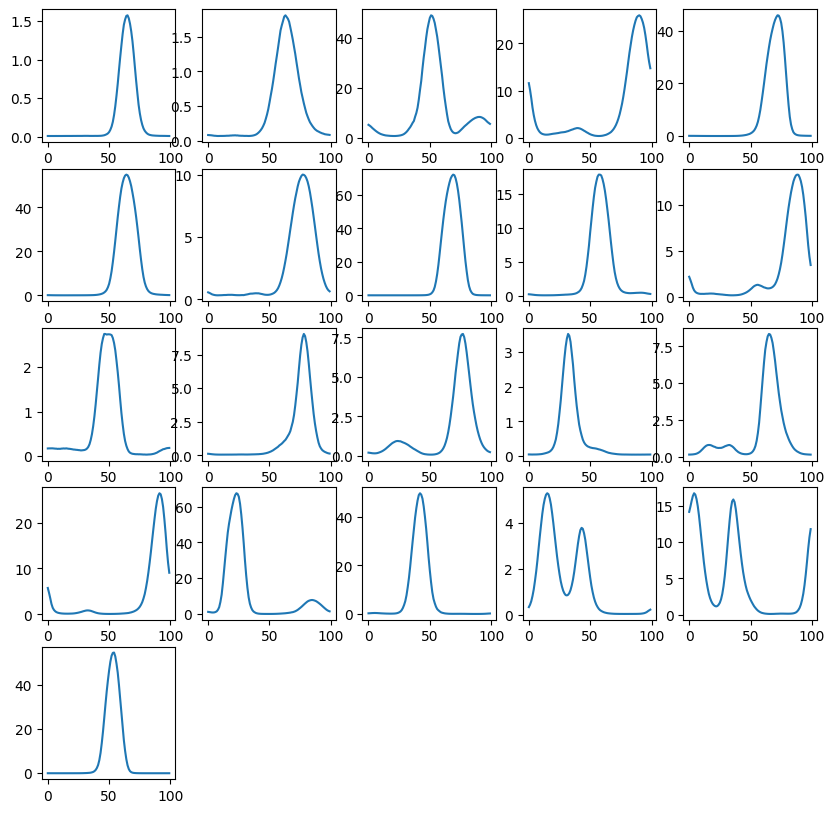

In [50]:
lower, mean, upper = utils.signal.percentiles_from_samples(hd_rate, [0.05, 0.5, 0.95])

fig = plt.figure(figsize=(10, 10))
for i in range(mean.shape[0]):
    ax = fig.add_subplot(5, 5, i+1)
    ax.plot(mean[i])

plt.show()


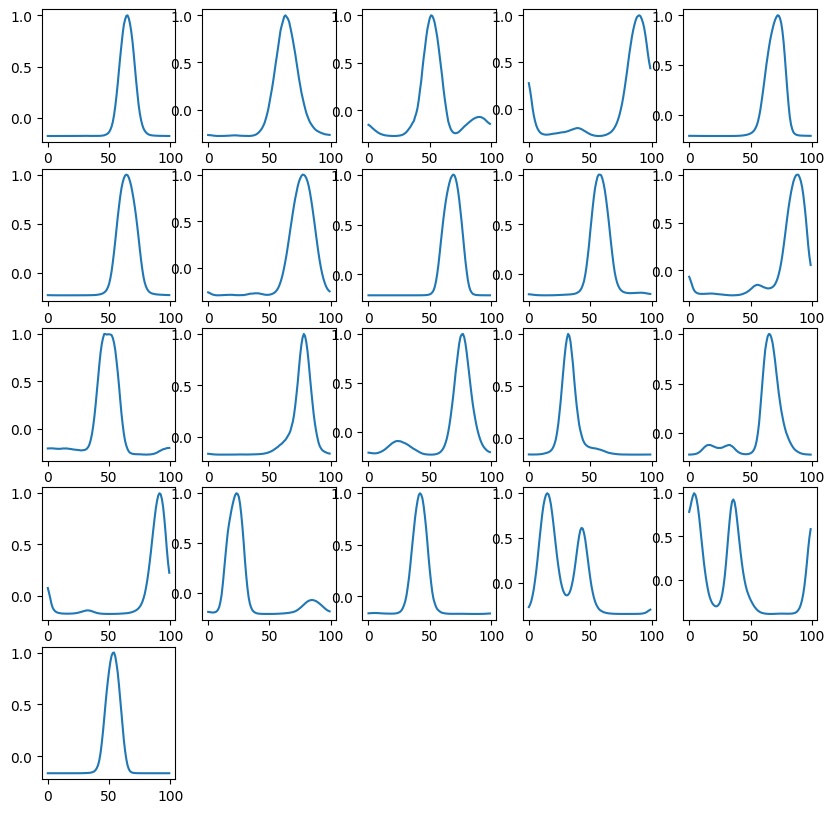

In [55]:
m = np.mean(mean.numpy(), axis=1)
maximum = np.max(mean.numpy() - m[:, None], axis=1)
tc = (mean - m[:, None]) / maximum[:, None] # normalized tuning curves

fig = plt.figure(figsize=(10, 10))
for i in range(tc.shape[0]):
    ax = fig.add_subplot(5, 5, i+1)
    ax.plot(tc[i])

plt.show()


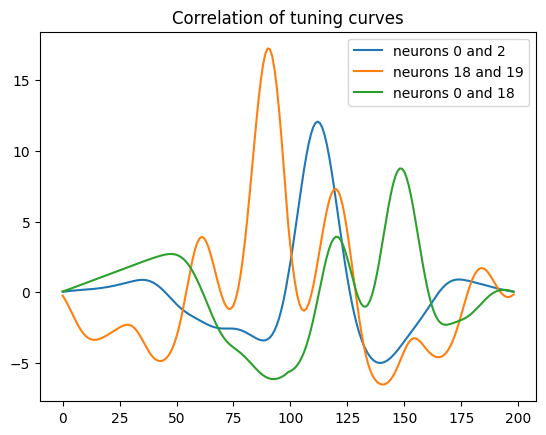

In [56]:
plt.title('Correlation of tuning curves')
c = np.correlate(tc[0], tc[2], mode='full')

plt.plot(c, label='neurons 0 and 2')
c = np.correlate(tc[19], tc[18], mode='full')

plt.plot(c, label='neurons 18 and 19')
c = np.correlate(tc[0], tc[18], mode='full')

plt.plot(c, label='neurons 0 and 18')
plt.legend()

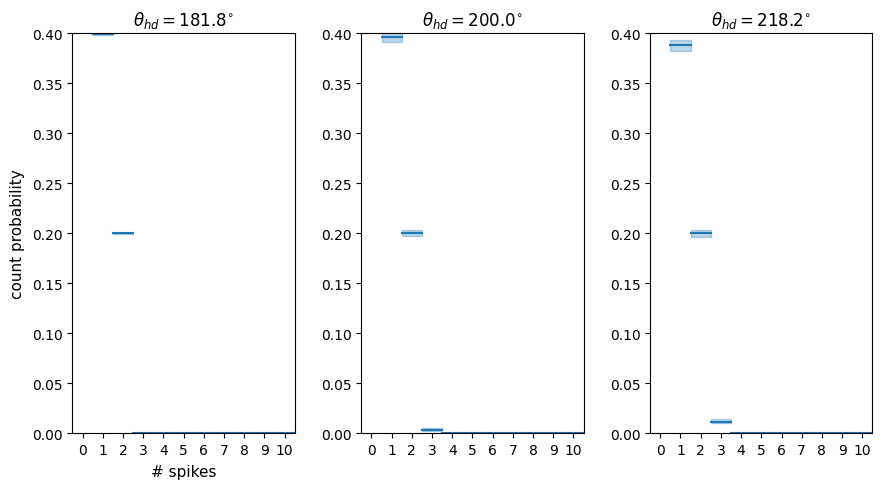

In [47]:
lower, mean, upper = utils.signal.percentiles_from_samples(P_mc, [0.05, 0.5, 0.95]) # (neurons, steps, count)

fig = plt.figure(figsize=(8, 4))
widths = [1, 1, 1]
heights = [1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths,
                        height_ratios=heights, top=1., bottom=0.0,
                        left=0., right=1., wspace=0.3)

ne = 0  # select neuron

K = P_mc.shape[-1] # max count
for en, step_ind in enumerate([50, 55, 60]):
    ax = fig.add_subplot(spec[0, en])
    hd = hd_sweep[step_ind]
    ax.set_title(r'$\theta_{hd} = $' + '{:.1f}'.format(hd / np.pi * 180) + r'$^{\circ}$')

    for k in range(K):
        XX_ = np.linspace(k-0.5, k+0.5, 2)
        YY_ = np.ones(2)*mean.numpy()[ne, step_ind, k]
        YY_l = np.ones(2)*lower.numpy()[ne, step_ind, k]
        YY_u = np.ones(2)*upper.numpy()[ne, step_ind, k]
        line, = ax.plot(XX_, YY_, c='tab:blue', alpha=1.)
        ax.fill_between(XX_, YY_l,
            YY_u, color=line.get_color(), alpha=0.3)


    ax.set_xlim([-0.5, K-1+.5])
    ax.set_ylim(0, 0.4)
    ax.set_xticks(np.arange(K))

    if en == 0:
        ax.set_ylabel('count probability', fontsize=11, labelpad=5)
        ax.set_xlabel('# spikes', labelpad=5, fontsize=11)

plt.show()